In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.colors import LinearSegmentedColormap
from collections import Counter
import warnings
import matplotlib.pyplot as plt

In [8]:
df = pd.read_csv(
    "/Users/alinetheo/Documents/Columbia/Summer 2025/Methods as Practice/Final Research Project/Data/MycoDB_version4-edit.csv"
)

In [21]:
max_plant_nodes = 100
max_fungal_nodes = 50
min_connections = 2

In [22]:
# Clean the data - remove rows where either plant or fungal genus is NA
df_clean = df.dropna(subset=["PlantSpecies", "FungalGenus"])
df_clean = df_clean[df_clean["FungalGenus"] != "NA"]
print(f"After cleaning: {df_clean.shape[0]} valid relationships")

After cleaning: 3399 valid relationships


In [23]:
# Get the most connected species for better visualization
plant_counts = df_clean["PlantSpecies"].value_counts()
fungal_counts = df_clean["FungalGenus"].value_counts()

In [24]:
# Filter to most connected nodes
top_plants = plant_counts.head(max_plant_nodes).index.tolist()
top_fungi = fungal_counts.head(max_fungal_nodes).index.tolist()

In [25]:
# Filter data to include only top connected species
df_filtered = df_clean[
    (df_clean["PlantSpecies"].isin(top_plants))
    & (df_clean["FungalGenus"].isin(top_fungi))
]

In [26]:
print(f"Filtered to {len(top_plants)} plant species and {len(top_fungi)} fungal genera")
print(f"Creating network with {df_filtered.shape[0]} relationships")

Filtered to 100 plant species and 50 fungal genera
Creating network with 2887 relationships


In [27]:
# Create bipartite network
G = nx.Graph()

In [28]:
# Add plant nodes (will be orange/yellow in visualization)
for plant in top_plants:
    plant_data = df_filtered[df_filtered["PlantSpecies"] == plant].iloc[0]
    G.add_node(
        f"P_{plant}",
        node_type="plant",
        family=plant_data["PlantFamily"],
        life_history=plant_data["PLANTLIFEHISTORY"],
        domesticated=plant_data["DOMESTICATED"],
        connections=plant_counts[plant],
    )

In [29]:
# Add fungal nodes (will be purple/magenta in visualization)
for fungus in top_fungi:
    G.add_node(f"F_{fungus}", node_type="fungal", connections=fungal_counts[fungus])

In [30]:
# Add edges based on relationships in the data
for _, row in df_filtered.iterrows():
    plant_node = f"P_{row['PlantSpecies']}"
    fungal_node = f"F_{row['FungalGenus']}"

    if G.has_node(plant_node) and G.has_node(fungal_node):
        if G.has_edge(plant_node, fungal_node):
            G[plant_node][fungal_node]["weight"] += 1
        else:
            G.add_edge(
                plant_node,
                fungal_node,
                weight=1,
                location=row["LOCATION"],
                fungroup=row["FUNGROUP"],
            )

print(f"Network created: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

Network created: 150 nodes, 368 edges


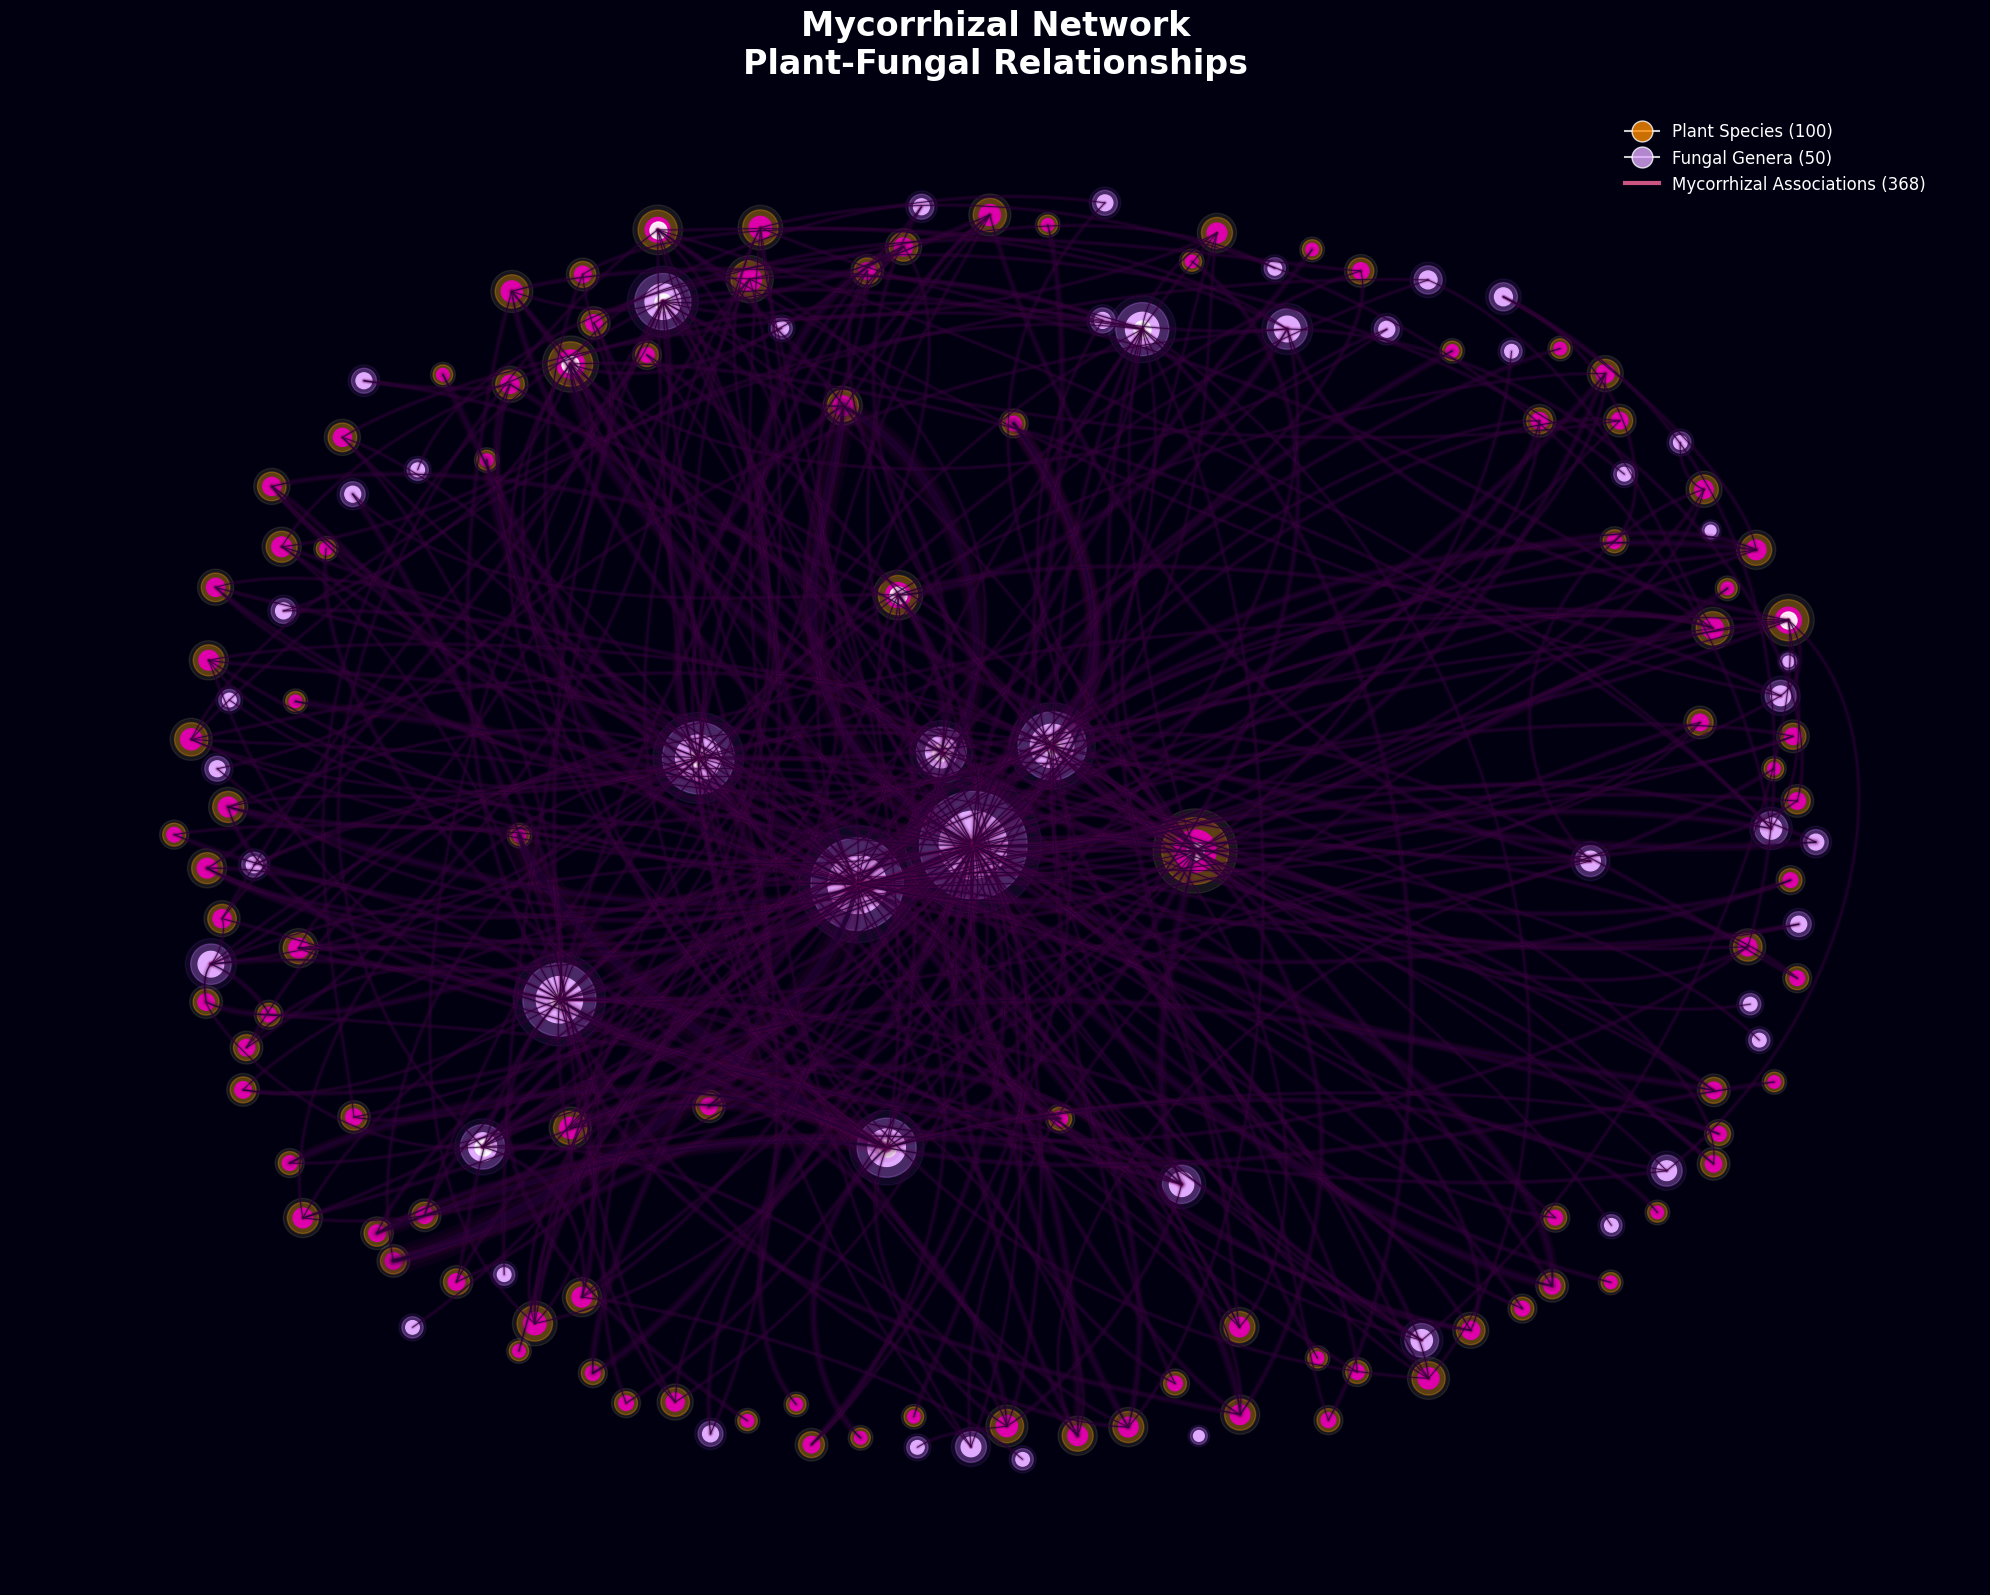

In [ ]:
# Create the visualization with neural network styling
fig, ax = plt.subplots(figsize=(20, 16))
fig.patch.set_facecolor("#000011")  # Very dark blue-black background
ax.set_facecolor("#000011")

# Use spring layout for organic network appearance
pos = nx.spring_layout(G, k=3, iterations=50, seed=42)

# Separate nodes by type for different styling
plant_nodes = [n for n in G.nodes() if n.startswith("P_")]
fungal_nodes = [n for n in G.nodes() if n.startswith("F_")]

# Get node sizes based on connections (degree)
plant_sizes = [G.degree(node) * 30 + 50 for node in plant_nodes]
fungal_sizes = [G.degree(node) * 35 + 60 for node in fungal_nodes]

# Get edge weights for thickness
edges = G.edges()
edge_weights = [G[u][v]["weight"] for u, v in edges]
max_weight = max(edge_weights) if edge_weights else 1
edge_widths = [w / max_weight * 3 + 0.5 for w in edge_weights]

# Draw edges with organic curves and glow effect
for i, (u, v) in enumerate(edges):
    # Get start and end points
    x1, y1 = pos[u]
    x2, y2 = pos[v]

    # Calculate curve parameters for organic appearance
    # Add some randomness based on node names for consistency
    np.random.seed(hash(str(u) + str(v)) % 2**32)

    # Create control points for cubic bezier curve
    # Distance between nodes affects curve intensity
    distance = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    curve_intensity = distance * 0.3  # Adjust this for more/less curvature

    # Perpendicular direction for curve offset
    dx, dy = x2 - x1, y2 - y1
    perp_x, perp_y = -dy, dx  # Perpendicular vector
    norm = np.sqrt(perp_x**2 + perp_y**2)
    if norm > 0:
        perp_x, perp_y = perp_x / norm, perp_y / norm

    # Random curve direction and intensity
    curve_direction = np.random.choice([-1, 1])
    curve_offset = curve_intensity * curve_direction * np.random.uniform(0.5, 1.5)

    # Control points for cubic bezier
    mid_x = (x1 + x2) / 2 + perp_x * curve_offset
    mid_y = (y1 + y2) / 2 + perp_y * curve_offset

    # Additional control point for more organic S-curves
    t1, t2 = 0.33, 0.66
    ctrl1_x = (
        x1 + t1 * (mid_x - x1) + perp_x * curve_offset * 0.3 * np.random.uniform(-1, 1)
    )
    ctrl1_y = (
        y1 + t1 * (mid_y - y1) + perp_y * curve_offset * 0.3 * np.random.uniform(-1, 1)
    )
    ctrl2_x = (
        x2 + t2 * (mid_x - x2) + perp_x * curve_offset * 0.3 * np.random.uniform(-1, 1)
    )
    ctrl2_y = (
        y2 + t2 * (mid_y - y2) + perp_y * curve_offset * 0.3 * np.random.uniform(-1, 1)
    )

    # Generate smooth curve points using parametric equations
    t_values = np.linspace(0, 1, 50)  # 50 points for smooth curve
    curve_x = []
    curve_y = []

    for t in t_values:
        # Cubic bezier curve formula
        x = (
            (1 - t) ** 3 * x1
            + 3 * (1 - t) ** 2 * t * ctrl1_x
            + 3 * (1 - t) * t**2 * ctrl2_x
            + t**3 * x2
        )
        y = (
            (1 - t) ** 3 * y1
            + 3 * (1 - t) ** 2 * t * ctrl1_y
            + 3 * (1 - t) * t**2 * ctrl2_y
            + t**3 * y2
        )
        curve_x.append(x)
        curve_y.append(y)

    # Draw the curved connection with glow layers
    base_width = edge_widths[i] if edge_widths else 1

    # Multiple layers for glow effect on curved lines - darker purple colors
    for width_mult, alpha, color in [
        (6, 0.08, "#930064"),
        (4, 0.15, "#49043B"),
        (2, 0.3, "#38015B"),
        (1, 0.8, "#19002A"),
    ]:
        ax.plot(
            curve_x,
            curve_y,
            color=color,
            linewidth=base_width * width_mult,
            alpha=alpha,
            solid_capstyle="round",
            solid_joinstyle="round",
        )

# Get coordinates for scatter plots
plant_x = [pos[node][0] for node in plant_nodes]
plant_y = [pos[node][1] for node in plant_nodes]
fungal_x = [pos[node][0] for node in fungal_nodes]
fungal_y = [pos[node][1] for node in fungal_nodes]

# Draw plant nodes with glow effect using scatter
for size_mult, alpha, color in [
    (4, 0.1, "#DED699"),
    (2.5, 0.3, "#FFA500"),
    (1, 1.0, "#DE00AA"),
]:
    ax.scatter(
        plant_x, plant_y, s=[s * size_mult for s in plant_sizes], c=color, alpha=alpha
    )

# Draw fungal nodes with glow effect using scatter
for size_mult, alpha, color in [
    (4, 0.1, "#9D4EDD"),
    (2.5, 0.3, "#C77DFF"),
    (1, 1.0, "#E0AAFF"),
]:
    ax.scatter(
        fungal_x,
        fungal_y,
        s=[s * size_mult for s in fungal_sizes],
        c=color,
        alpha=alpha,
    )

# Add bright accent nodes for high-degree nodes
high_degree_nodes = [
    n
    for n in G.nodes()
    if G.degree(n) > np.percentile([G.degree(n) for n in G.nodes()], 90)
]
if high_degree_nodes:
    high_x = [pos[node][0] for node in high_degree_nodes]
    high_y = [pos[node][1] for node in high_degree_nodes]
    ax.scatter(
        high_x, high_y, s=150, c="#FFFFFF", alpha=0.9, edgecolors="white", linewidth=1
    )

# Set dynamic plot limits based on actual node positions
all_x = [pos[node][0] for node in G.nodes()]
all_y = [pos[node][1] for node in G.nodes()]
x_margin = (max(all_x) - min(all_x)) * 0.1
y_margin = (max(all_y) - min(all_y)) * 0.1

ax.set_xlim(min(all_x) - x_margin, max(all_x) + x_margin)
ax.set_ylim(min(all_y) - y_margin, max(all_y) + y_margin)
ax.axis("off")

# Add title with glowing effect
title_text = "Mycorrhizal Network\nPlant-Fungal Relationships"
ax.text(
    0,
    1.25,
    title_text,
    fontsize=24,
    fontweight="bold",
    ha="center",
    va="center",
    color="white",
    family="sans-serif",
    zorder=10,
)

# Add legend
legend_elements = [
    plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor="#FF8C00",
        markersize=15,
        label=f"Plant Species ({len(plant_nodes)})",
        alpha=0.8,
    ),
    plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor="#E0AAFF",
        markersize=15,
        label=f"Fungal Genera ({len(fungal_nodes)})",
        alpha=0.8,
    ),
    plt.Line2D(
        [0],
        [0],
        color="#FF6B9D",
        linewidth=3,
        label=f"Mycorrhizal Associations ({G.number_of_edges()})",
        alpha=0.8,
    ),
]

legend = ax.legend(
    handles=legend_elements,
    loc="upper right",
    frameon=False,
    fontsize=12,
    bbox_to_anchor=(0.98, 0.98),
)
for text in legend.get_texts():
    text.set_color("white")

plt.tight_layout()
plt.show()

Creating organic network layout...
Layout complete using fruchterman method


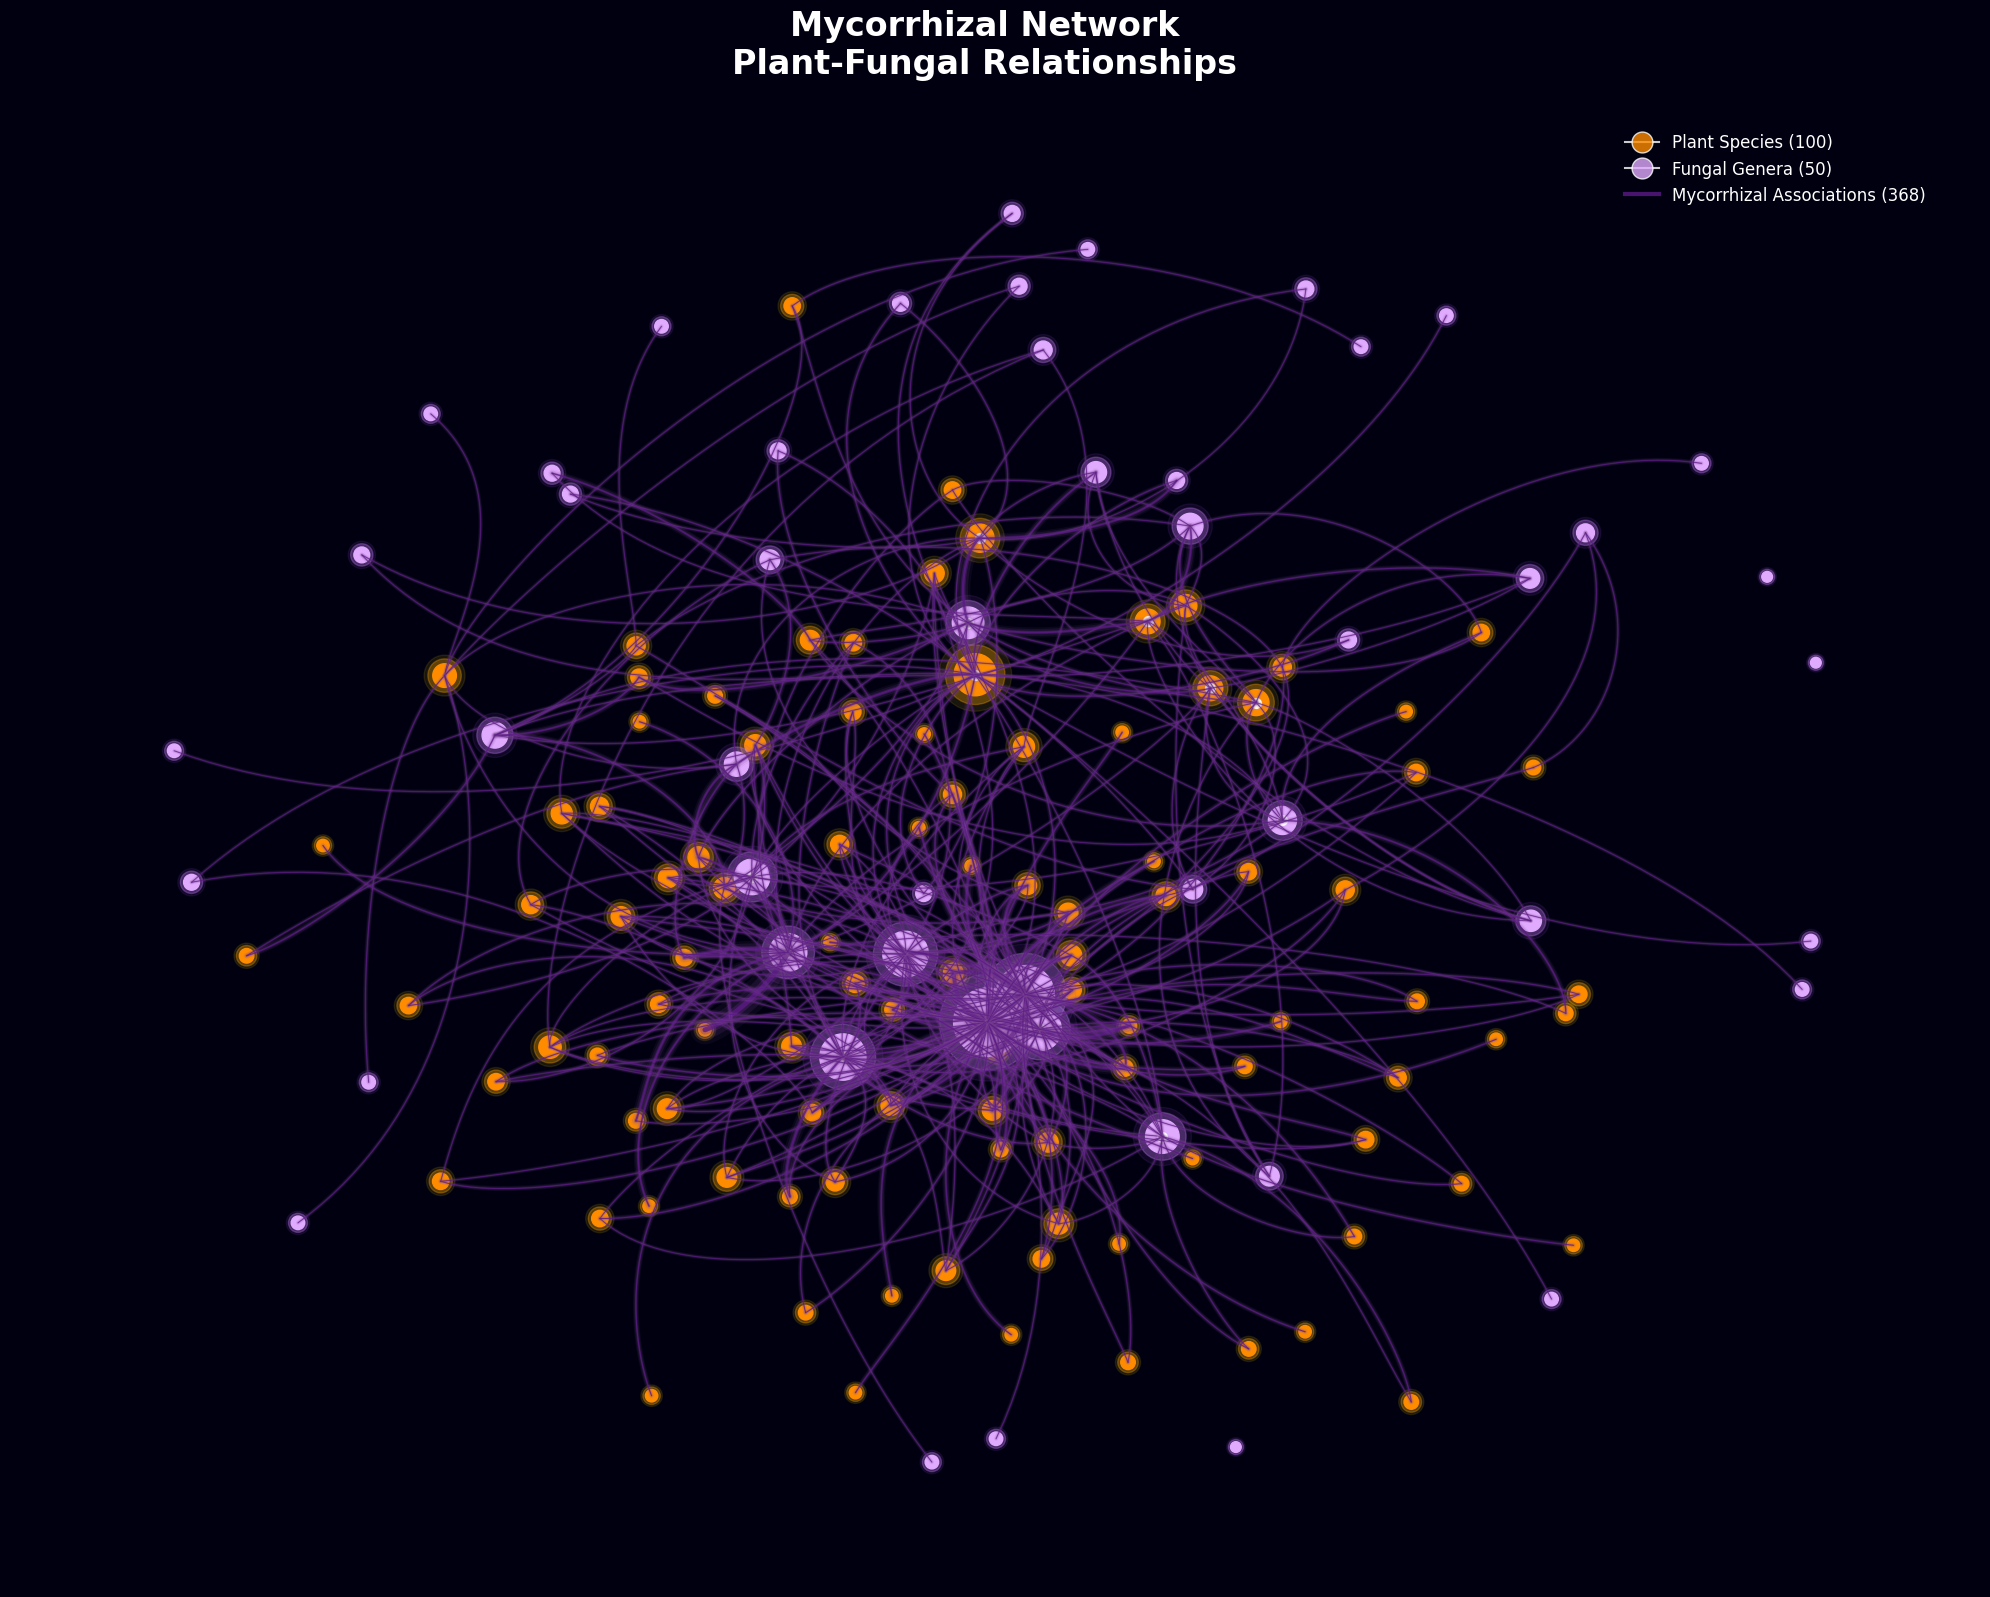

In [70]:
# Create the visualization with neural network styling
fig, ax = plt.subplots(figsize=(20, 16))
fig.patch.set_facecolor("#000011")  # Very dark blue-black background
ax.set_facecolor("#000011")

# Use more organic layout with variation to avoid circular patterns
print("Creating organic network layout...")

# Try different layout approaches for more natural distribution
layout_method = (
    "fruchterman"  # Change this to: 'organic', 'kamada', 'fruchterman', or 'spring'
)

if layout_method == "organic":
    # Multi-step organic layout approach
    # Start with spring layout but with more variation
    pos = nx.spring_layout(G, k=2.5, iterations=100, seed=123, weight="weight")

    # Add some organic clustering based on node types and families
    plant_families = {}
    for node in plant_nodes:
        if node in G.nodes():
            family = G.nodes[node].get("family", "unknown")
            if family not in plant_families:
                plant_families[family] = []
            plant_families[family].append(node)

    # Slightly cluster nodes by plant family for more realistic grouping
    np.random.seed(42)
    for family, nodes in plant_families.items():
        if len(nodes) > 1:
            # Create a small random offset for family clustering
            family_center_x = np.random.uniform(-0.3, 0.3)
            family_center_y = np.random.uniform(-0.3, 0.3)

            for node in nodes:
                if node in pos:
                    # Add small offset toward family center
                    pos[node] = (
                        pos[node][0] + family_center_x * 0.1,
                        pos[node][1] + family_center_y * 0.1,
                    )

    # Add random perturbations to break symmetry
    for node in pos:
        pos[node] = (
            pos[node][0] + np.random.normal(0, 0.1),
            pos[node][1] + np.random.normal(0, 0.1),
        )

elif layout_method == "kamada":
    # Kamada-Kawai layout - good for avoiding circular patterns
    pos = nx.kamada_kawai_layout(G, weight="weight")

elif layout_method == "fruchterman":
    # Fruchterman-Reingold layout - more organic than spring
    pos = nx.fruchterman_reingold_layout(
        G, k=1.5, iterations=100, seed=42, weight="weight"
    )

else:  # 'spring'
    # Enhanced spring layout with more parameters
    pos = nx.spring_layout(G, k=3.5, iterations=150, seed=42, weight="weight")

print(f"Layout complete using {layout_method} method")

# Separate nodes by type for different styling
plant_nodes = [n for n in G.nodes() if n.startswith("P_")]
fungal_nodes = [n for n in G.nodes() if n.startswith("F_")]

# Get node sizes based on connections (degree) - much smaller
plant_sizes = [
    G.degree(node) * 30 + 50 for node in plant_nodes
]  # Reduced from *100 + 200
fungal_sizes = [
    G.degree(node) * 35 + 60 for node in fungal_nodes
]  # Reduced from *120 + 250

# Get edge weights for thickness
edges = G.edges()
edge_weights = [G[u][v]["weight"] for u, v in edges]
max_weight = max(edge_weights) if edge_weights else 1
edge_widths = [w / max_weight * 3 + 0.5 for w in edge_weights]

# Draw edges with organic curves and glow effect
for i, (u, v) in enumerate(edges):
    # Get start and end points
    x1, y1 = pos[u]
    x2, y2 = pos[v]

    # Calculate curve parameters for organic appearance
    # Add some randomness based on node names for consistency
    np.random.seed(hash(str(u) + str(v)) % 2**32)

    # Create control points for cubic bezier curve
    # Distance between nodes affects curve intensity
    distance = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    curve_intensity = distance * 0.3  # Adjust this for more/less curvature

    # Perpendicular direction for curve offset
    dx, dy = x2 - x1, y2 - y1
    perp_x, perp_y = -dy, dx  # Perpendicular vector
    norm = np.sqrt(perp_x**2 + perp_y**2)
    if norm > 0:
        perp_x, perp_y = perp_x / norm, perp_y / norm

    # Random curve direction and intensity
    curve_direction = np.random.choice([-1, 1])
    curve_offset = curve_intensity * curve_direction * np.random.uniform(0.5, 1.5)

    # Control points for cubic bezier
    mid_x = (x1 + x2) / 2 + perp_x * curve_offset
    mid_y = (y1 + y2) / 2 + perp_y * curve_offset

    # Additional control point for more organic S-curves
    t1, t2 = 0.33, 0.66
    ctrl1_x = (
        x1 + t1 * (mid_x - x1) + perp_x * curve_offset * 0.3 * np.random.uniform(-1, 1)
    )
    ctrl1_y = (
        y1 + t1 * (mid_y - y1) + perp_y * curve_offset * 0.3 * np.random.uniform(-1, 1)
    )
    ctrl2_x = (
        x2 + t2 * (mid_x - x2) + perp_x * curve_offset * 0.3 * np.random.uniform(-1, 1)
    )
    ctrl2_y = (
        y2 + t2 * (mid_y - y2) + perp_y * curve_offset * 0.3 * np.random.uniform(-1, 1)
    )

    # Generate smooth curve points using parametric equations
    t_values = np.linspace(0, 1, 50)  # 50 points for smooth curve
    curve_x = []
    curve_y = []

    for t in t_values:
        # Cubic bezier curve formula
        x = (
            (1 - t) ** 3 * x1
            + 3 * (1 - t) ** 2 * t * ctrl1_x
            + 3 * (1 - t) * t**2 * ctrl2_x
            + t**3 * x2
        )
        y = (
            (1 - t) ** 3 * y1
            + 3 * (1 - t) ** 2 * t * ctrl1_y
            + 3 * (1 - t) * t**2 * ctrl2_y
            + t**3 * y2
        )
        curve_x.append(x)
        curve_y.append(y)

    # Draw the curved connection with glow layers - darker purple
    base_width = edge_widths[i] if edge_widths else 1

    # Multiple layers for glow effect on curved lines - darker purple colors
    for width_mult, alpha, color in [
        (6, 0.08, "#8B5A96"),
        (4, 0.15, "#7B4397"),
        (2, 0.3, "#6B2C91"),
        (1, 0.8, "#5B1A85"),
    ]:
        ax.plot(
            curve_x,
            curve_y,
            color=color,
            linewidth=base_width * width_mult,
            alpha=alpha,
            solid_capstyle="round",
            solid_joinstyle="round",
        )

# Get coordinates for scatter plots
plant_x = [pos[node][0] for node in plant_nodes]
plant_y = [pos[node][1] for node in plant_nodes]
fungal_x = [pos[node][0] for node in fungal_nodes]
fungal_y = [pos[node][1] for node in fungal_nodes]

# Draw plant nodes with glow effect using scatter - smaller sizes
for size_mult, alpha, color in [
    (3, 0.1, "#FFD700"),
    (2, 0.3, "#FFA500"),
    (1, 1.0, "#FF8C00"),
]:  # Reduced multipliers
    ax.scatter(
        plant_x, plant_y, s=[s * size_mult for s in plant_sizes], c=color, alpha=alpha
    )

# Draw fungal nodes with glow effect using scatter - smaller sizes
for size_mult, alpha, color in [
    (3, 0.1, "#9D4EDD"),
    (2, 0.3, "#C77DFF"),
    (1, 1.0, "#E0AAFF"),
]:  # Reduced multipliers
    ax.scatter(
        fungal_x,
        fungal_y,
        s=[s * size_mult for s in fungal_sizes],
        c=color,
        alpha=alpha,
    )

# Add bright accent nodes for high-degree nodes - smaller
high_degree_nodes = [
    n
    for n in G.nodes()
    if G.degree(n) > np.percentile([G.degree(n) for n in G.nodes()], 90)
]
if high_degree_nodes:
    high_x = [pos[node][0] for node in high_degree_nodes]
    high_y = [pos[node][1] for node in high_degree_nodes]
    ax.scatter(
        high_x, high_y, s=50, c="#FFFFFF", alpha=0.9, edgecolors="white", linewidth=1
    )  # Reduced from s=150

# Set dynamic plot limits based on actual node positions
all_x = [pos[node][0] for node in G.nodes()]
all_y = [pos[node][1] for node in G.nodes()]
x_margin = (max(all_x) - min(all_x)) * 0.1
y_margin = (max(all_y) - min(all_y)) * 0.1

ax.set_xlim(min(all_x) - x_margin, max(all_x) + x_margin)
ax.set_ylim(min(all_y) - y_margin, max(all_y) + y_margin)
ax.axis("off")

# Add title with glowing effect
title_text = "Mycorrhizal Network\nPlant-Fungal Relationships"
ax.text(
    0,
    1.25,
    title_text,
    fontsize=24,
    fontweight="bold",
    ha="center",
    va="center",
    color="white",
    family="sans-serif",
    zorder=10,
)

# Add legend
legend_elements = [
    plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor="#FF8C00",
        markersize=15,
        label=f"Plant Species ({len(plant_nodes)})",
        alpha=0.8,
    ),
    plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor="#E0AAFF",
        markersize=15,
        label=f"Fungal Genera ({len(fungal_nodes)})",
        alpha=0.8,
    ),
    plt.Line2D(
        [0],
        [0],
        color="#5B1A85",
        linewidth=3,
        label=f"Mycorrhizal Associations ({G.number_of_edges()})",
        alpha=0.8,
    ),
]

legend = ax.legend(
    handles=legend_elements,
    loc="upper right",
    frameon=False,
    fontsize=12,
    bbox_to_anchor=(0.98, 0.98),
)
for text in legend.get_texts():
    text.set_color("white")

plt.tight_layout()
plt.show()

Creating organic network layout...
Layout complete using organic method


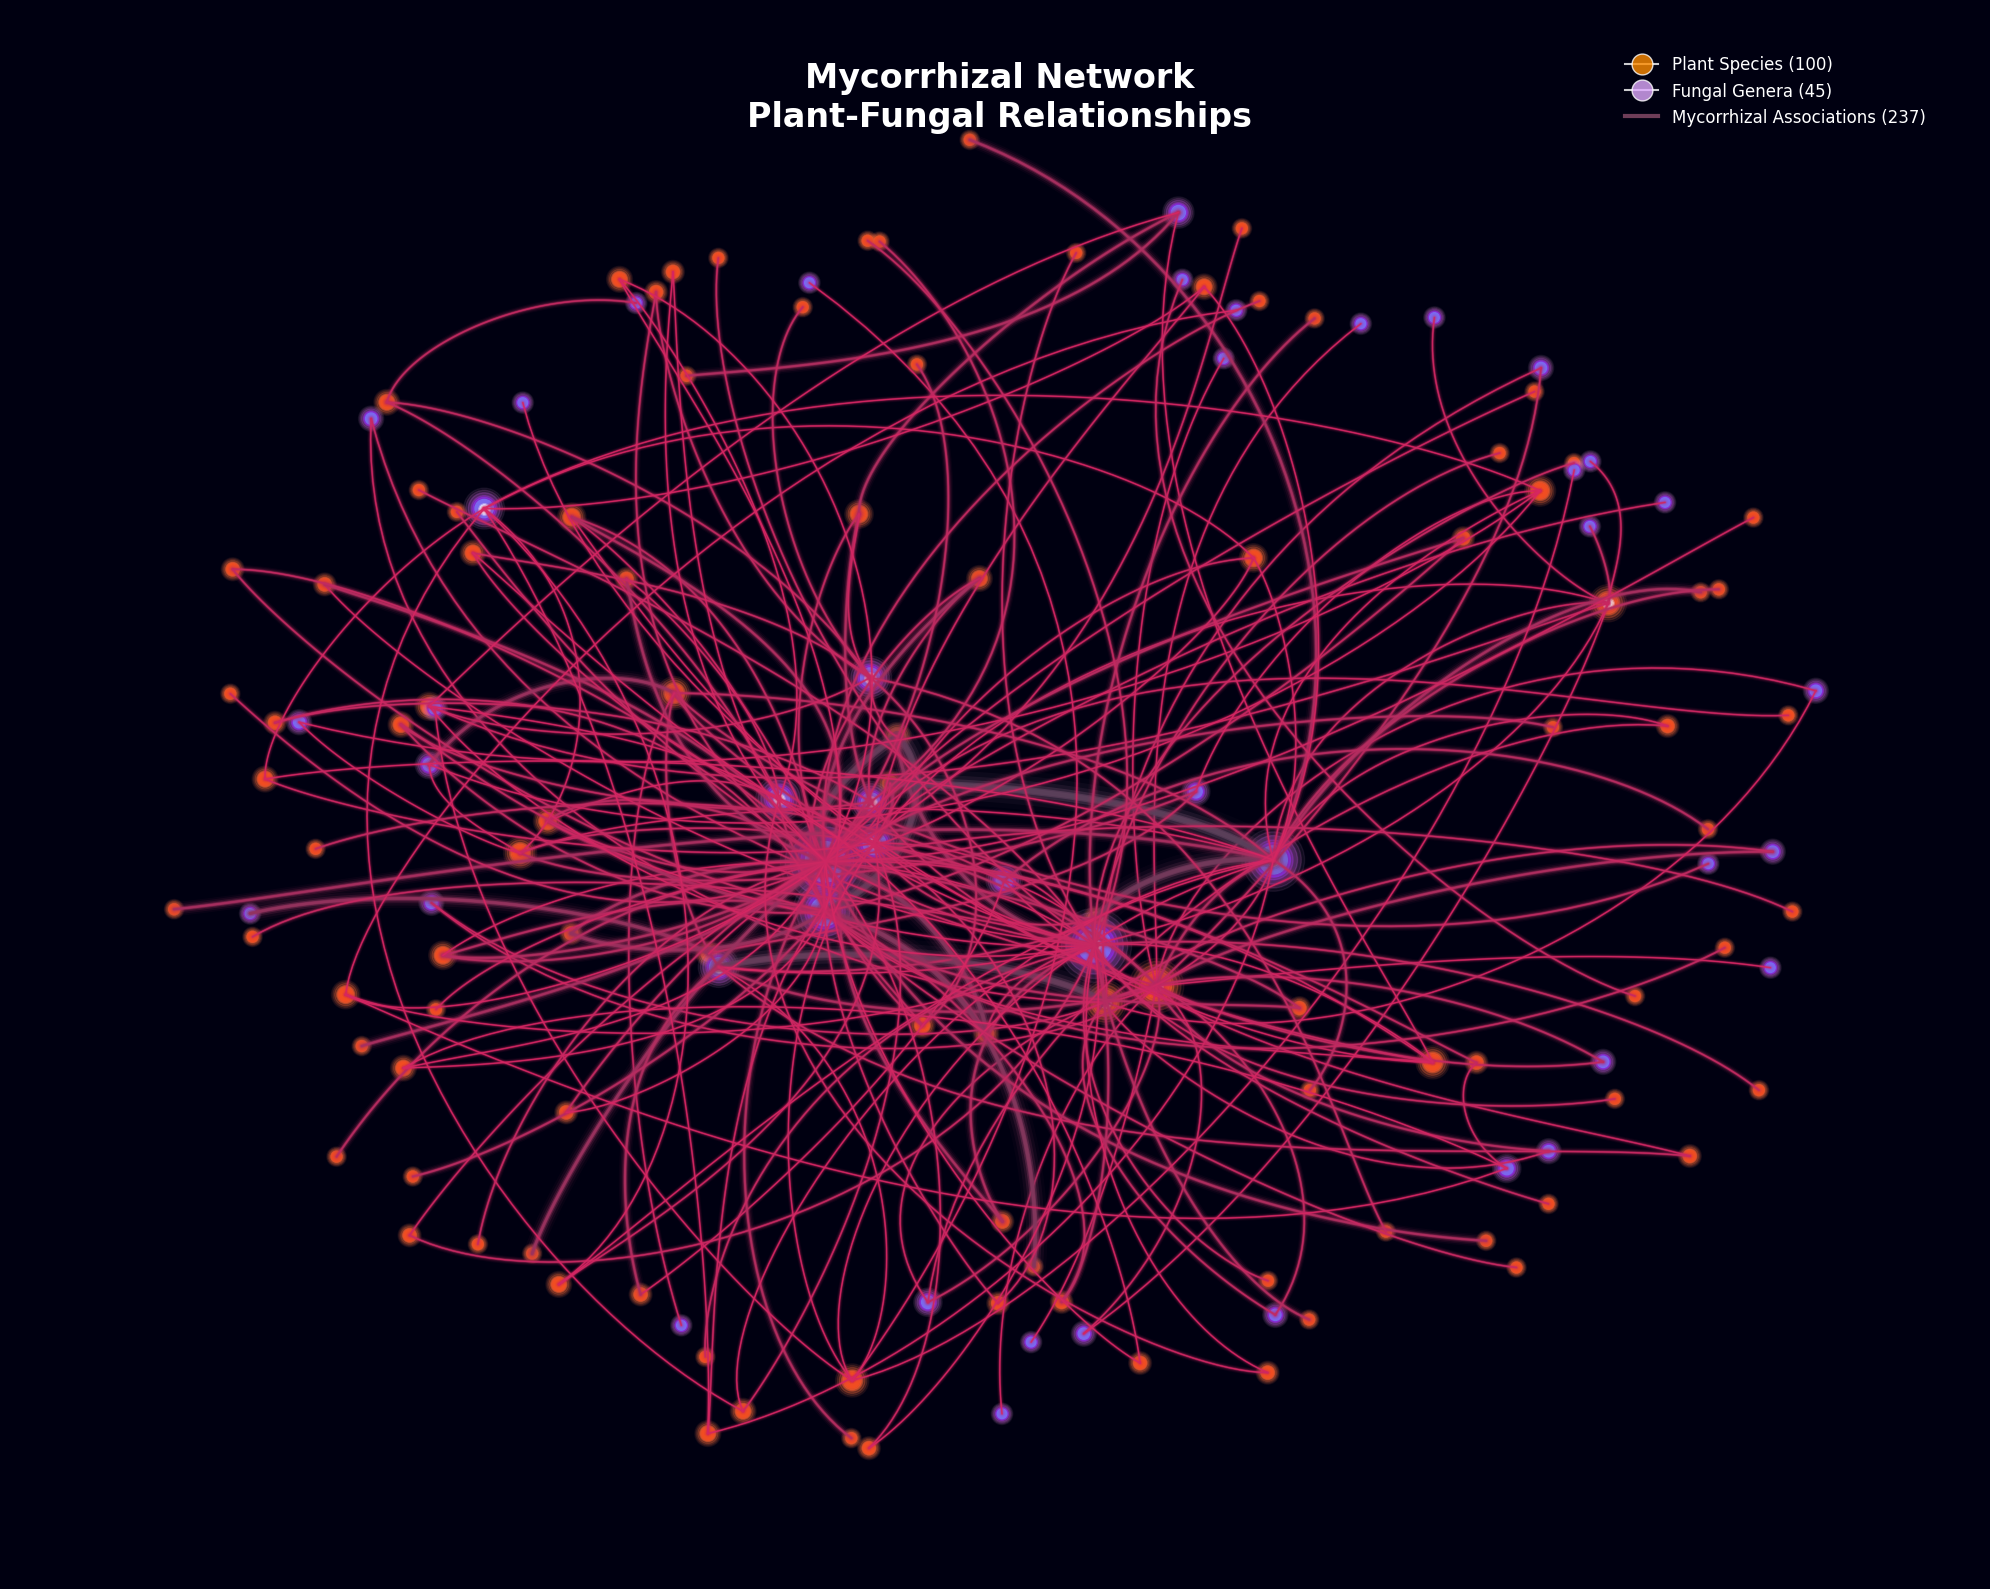

Vector files saved:
- mycorrhizal_network.svg (SVG format)
- mycorrhizal_network.pdf (PDF format)


<Figure size 640x480 with 0 Axes>


MYCORRHIZAL NETWORK STATISTICS
Total nodes: 145
Plant species: 100
Fungal genera: 45
Total associations: 237
Network density: 0.023
Average degree: 3.27

Most connected species:
  Fungus: Rhizophagus (45 associations)
  Fungus: Claroideoglomus (30 associations)
  Fungus: Funneliformis (22 associations)
  Fungus: Pisolithus (21 associations)
  Plant: Eucalyptus Globulus (19 associations)
  Fungus: Scleroderma (13 associations)
  Plant: Eucalyptus Diversicolor (12 associations)
  Fungus: Gigaspora (11 associations)
  Fungus: Acaulospora (9 associations)
  Plant: Eucalyptus Miniata (8 associations)


SyntaxError: 'return' outside function (3113199283.py, line 383)

In [97]:
# Create the visualization with neural network styling
fig, ax = plt.subplots(figsize=(20, 16))
fig.patch.set_facecolor("#000011")  # Very dark blue-black background
ax.set_facecolor("#000011")

# Use more organic layout with variation to avoid circular patterns
print("Creating organic network layout...")

# Try different layout approaches for more natural distribution
layout_method = (
    "organic"  # Change this to: 'organic', 'kamada', 'fruchterman', or 'spring'
)

if layout_method == "organic":
    # Multi-step organic layout approach
    # Start with spring layout but with more variation
    pos = nx.spring_layout(G, k=2.5, iterations=100, seed=42, weight="weight")

    # Add some organic clustering based on node types and families
    plant_families = {}
    for node in plant_nodes:
        if node in G.nodes():
            family = G.nodes[node].get("family", "unknown")
            if family not in plant_families:
                plant_families[family] = []
            plant_families[family].append(node)

    # Slightly cluster nodes by plant family for more realistic grouping
    np.random.seed(42)
    for family, nodes in plant_families.items():
        if len(nodes) > 1:
            # Create a small random offset for family clustering
            family_center_x = np.random.uniform(-0.3, 0.3)
            family_center_y = np.random.uniform(-0.3, 0.3)

            for node in nodes:
                if node in pos:
                    # Add small offset toward family center
                    pos[node] = (
                        pos[node][0] + family_center_x * 0.1,
                        pos[node][1] + family_center_y * 0.1,
                    )

    # Add random perturbations to break symmetry
    for node in pos:
        pos[node] = (
            pos[node][0] + np.random.normal(0, 0.1),
            pos[node][1] + np.random.normal(0, 0.1),
        )

elif layout_method == "kamada":
    # Kamada-Kawai layout - good for avoiding circular patterns
    pos = nx.kamada_kawai_layout(G, weight="weight")

elif layout_method == "fruchterman":
    # Fruchterman-Reingold layout - more organic than spring
    pos = nx.fruchterman_reingold_layout(
        G, k=1.5, iterations=100, seed=42, weight="weight"
    )

else:  # 'spring'
    # Enhanced spring layout with more parameters
    pos = nx.spring_layout(G, k=3.5, iterations=150, seed=42, weight="weight")

print(f"Layout complete using {layout_method} method")

# Separate nodes by type for different styling
plant_nodes = [n for n in G.nodes() if n.startswith("P_")]
fungal_nodes = [n for n in G.nodes() if n.startswith("F_")]

# Get node sizes based on connections (degree) - even smaller
plant_sizes = [
    G.degree(node) * 15 + 25 for node in plant_nodes
]  # Reduced from *30 + 50
fungal_sizes = [
    G.degree(node) * 18 + 30 for node in fungal_nodes
]  # Reduced from *35 + 60

# Get edge weights for thickness
edges = G.edges()
edge_weights = [G[u][v]["weight"] for u, v in edges]
max_weight = max(edge_weights) if edge_weights else 1
edge_widths = [w / max_weight * 3 + 0.5 for w in edge_weights]

# Draw edges with organic curves and glow effect
for i, (u, v) in enumerate(edges):
    # Get start and end points
    x1, y1 = pos[u]
    x2, y2 = pos[v]

    # Calculate curve parameters for organic appearance
    # Add some randomness based on node names for consistency
    np.random.seed(hash(str(u) + str(v)) % 2**32)

    # Create control points for cubic bezier curve
    # Distance between nodes affects curve intensity
    distance = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    curve_intensity = distance * 0.3  # Adjust this for more/less curvature

    # Perpendicular direction for curve offset
    dx, dy = x2 - x1, y2 - y1
    perp_x, perp_y = -dy, dx  # Perpendicular vector
    norm = np.sqrt(perp_x**2 + perp_y**2)
    if norm > 0:
        perp_x, perp_y = perp_x / norm, perp_y / norm

    # Random curve direction and intensity
    curve_direction = np.random.choice([-1, 1])
    curve_offset = curve_intensity * curve_direction * np.random.uniform(0.5, 1.5)

    # Control points for cubic bezier
    mid_x = (x1 + x2) / 2 + perp_x * curve_offset
    mid_y = (y1 + y2) / 2 + perp_y * curve_offset

    # Additional control point for more organic S-curves
    t1, t2 = 0.33, 0.66
    ctrl1_x = (
        x1 + t1 * (mid_x - x1) + perp_x * curve_offset * 0.3 * np.random.uniform(-1, 1)
    )
    ctrl1_y = (
        y1 + t1 * (mid_y - y1) + perp_y * curve_offset * 0.3 * np.random.uniform(-1, 1)
    )
    ctrl2_x = (
        x2 + t2 * (mid_x - x2) + perp_x * curve_offset * 0.3 * np.random.uniform(-1, 1)
    )
    ctrl2_y = (
        y2 + t2 * (mid_y - y2) + perp_y * curve_offset * 0.3 * np.random.uniform(-1, 1)
    )

    # Generate smooth curve points using parametric equations
    t_values = np.linspace(0, 1, 50)  # 50 points for smooth curve
    curve_x = []
    curve_y = []

    for t in t_values:
        # Cubic bezier curve formula
        x = (
            (1 - t) ** 3 * x1
            + 3 * (1 - t) ** 2 * t * ctrl1_x
            + 3 * (1 - t) * t**2 * ctrl2_x
            + t**3 * x2
        )
        y = (
            (1 - t) ** 3 * y1
            + 3 * (1 - t) ** 2 * t * ctrl1_y
            + 3 * (1 - t) * t**2 * ctrl2_y
            + t**3 * y2
        )
        curve_x.append(x)
        curve_y.append(y)

    # Generate color based on connection strength (weight) with more purple variation
    if edge_weights:
        weight = edge_weights[i]
        max_weight = max(edge_weights)

        # Color interpolation from pink to purple based on weight
        # Normalize weight to 0-1 range with more bias toward purple
        weight_norm = weight / max_weight if max_weight > 0 else 0
        # Apply power function to create more purple lines (bias toward higher values)
        weight_norm = weight_norm**0.6  # This will make more lines purple

        # Create color gradient: pink (#e52364) to purple (#5c405b)
        # Pink: #e52364 -> RGB(229, 35, 100)
        # Purple: #5c405b -> RGB(92, 64, 91)
        pink_r, pink_g, pink_b = 229, 35, 100
        purple_r, purple_g, purple_b = 92, 64, 91

        # Interpolate RGB values
        r = int(pink_r + (purple_r - pink_r) * weight_norm)
        g = int(pink_g + (purple_g - pink_g) * weight_norm)
        b = int(pink_b + (purple_b - pink_b) * weight_norm)

        # Convert to hex
        connection_color = f"#{r:02x}{g:02x}{b:02x}"
    else:
        connection_color = "#e52364"  # Default pink

    # Draw the curved connection with enhanced glow layers
    base_width = edge_widths[i] if edge_widths else 1

    # Enhanced glow effect with more layers
    glow_layers = [
        (8, 0.05, connection_color),  # Outermost glow (very faint)
        (6, 0.1, connection_color),  # Outer glow
        (4, 0.2, connection_color),  # Mid glow
        (2.5, 0.4, connection_color),  # Inner glow
        (1.5, 0.7, connection_color),  # Core bright
        (1, 0.9, connection_color),  # Innermost core
    ]

    for width_mult, alpha, color in glow_layers:
        ax.plot(
            curve_x,
            curve_y,
            color=color,
            linewidth=base_width * width_mult,
            alpha=alpha,
            solid_capstyle="round",
            solid_joinstyle="round",
        )

# Get coordinates for scatter plots
plant_x = [pos[node][0] for node in plant_nodes]
plant_y = [pos[node][1] for node in plant_nodes]
fungal_x = [pos[node][0] for node in fungal_nodes]
fungal_y = [pos[node][1] for node in fungal_nodes]

# Draw plant nodes with enhanced glow effect using scatter - updated orange color (#f15f31)
glow_layers_plants = [
    (5, 0.08, "#f17555"),  # Outermost glow - lighter version of #f15f31
    (4, 0.15, "#f16d43"),  # Outer glow
    (3, 0.25, "#f16637"),  # Mid glow
    (2, 0.4, "#f15f31"),  # Inner glow - your specified color
    (1.5, 0.7, "#f15529"),  # Core bright - slightly darker
    (1, 1.0, "#f14d21"),  # Innermost core - deepest orange
]

for size_mult, alpha, color in glow_layers_plants:
    ax.scatter(
        plant_x, plant_y, s=[s * size_mult for s in plant_sizes], c=color, alpha=alpha
    )

# Draw fungal nodes with enhanced glow effect using scatter - much smaller sizes
glow_layers_fungi = [
    (5, 0.08, "#DDA0DD"),  # Outermost glow
    (4, 0.15, "#DA70D6"),  # Outer glow
    (3, 0.25, "#BA55D3"),  # Mid glow
    (2, 0.4, "#9932CC"),  # Inner glow
    (1.5, 0.7, "#8A2BE2"),  # Core bright
    (1, 1.0, "#7B68EE"),  # Innermost core
]

for size_mult, alpha, color in glow_layers_fungi:
    ax.scatter(
        fungal_x,
        fungal_y,
        s=[s * size_mult for s in fungal_sizes],
        c=color,
        alpha=alpha,
    )

# Add bright accent nodes for high-degree nodes - much smaller
high_degree_nodes = [
    n
    for n in G.nodes()
    if G.degree(n) > np.percentile([G.degree(n) for n in G.nodes()], 90)
]
if high_degree_nodes:
    high_x = [pos[node][0] for node in high_degree_nodes]
    high_y = [pos[node][1] for node in high_degree_nodes]

    # Enhanced glow for accent nodes
    accent_glow_layers = [(3, 0.3, "#FFFFFF"), (2, 0.6, "#FFFFFF"), (1, 1.0, "#FFFFFF")]

    for size_mult, alpha, color in accent_glow_layers:
        ax.scatter(
            high_x,
            high_y,
            s=25 * size_mult,
            c=color,
            alpha=alpha,
            edgecolors="white",
            linewidth=0.5,
        )

# Set dynamic plot limits based on actual node positions
all_x = [pos[node][0] for node in G.nodes()]
all_y = [pos[node][1] for node in G.nodes()]
x_margin = (max(all_x) - min(all_x)) * 0.1
y_margin = (max(all_y) - min(all_y)) * 0.1

ax.set_xlim(min(all_x) - x_margin, max(all_x) + x_margin)
ax.set_ylim(min(all_y) - y_margin, max(all_y) + y_margin)
ax.axis("off")

# Add title with glowing effect
title_text = "Mycorrhizal Network\nPlant-Fungal Relationships"
ax.text(
    0,
    1.25,
    title_text,
    fontsize=24,
    fontweight="bold",
    ha="center",
    va="center",
    color="white",
    family="sans-serif",
    zorder=10,
)

# Add legend
legend_elements = [
    plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor="#FF8C00",
        markersize=15,
        label=f"Plant Species ({len(plant_nodes)})",
        alpha=0.8,
    ),
    plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor="#E0AAFF",
        markersize=15,
        label=f"Fungal Genera ({len(fungal_nodes)})",
        alpha=0.8,
    ),
    plt.Line2D(
        [0],
        [0],
        color="#8a4d6b",
        linewidth=3,
        label=f"Mycorrhizal Associations ({G.number_of_edges()})",
        alpha=0.8,
    ),
]

legend = ax.legend(
    handles=legend_elements,
    loc="upper right",
    frameon=False,
    fontsize=12,
    bbox_to_anchor=(0.98, 0.98),
)
for text in legend.get_texts():
    text.set_color("white")

plt.tight_layout()
plt.show()

# Save as vector format before showing
plt.savefig(
    "mycorrhizal_network.svg",
    format="svg",
    dpi=300,
    bbox_inches="tight",
    facecolor="#000011",
    edgecolor="none",
    transparent=False,
)
plt.savefig(
    "mycorrhizal_network.pdf",
    format="pdf",
    dpi=300,
    bbox_inches="tight",
    facecolor="#000011",
    edgecolor="none",
    transparent=False,
)

print("Vector files saved:")
print("- mycorrhizal_network.svg (SVG format)")
print("- mycorrhizal_network.pdf (PDF format)")

plt.show()

# Print network statistics
print("\n" + "=" * 50)
print("MYCORRHIZAL NETWORK STATISTICS")
print("=" * 50)
print(f"Total nodes: {G.number_of_nodes()}")
print(f"Plant species: {len(plant_nodes)}")
print(f"Fungal genera: {len(fungal_nodes)}")
print(f"Total associations: {G.number_of_edges()}")
print(f"Network density: {nx.density(G):.3f}")
print(f"Average degree: {np.mean([G.degree(n) for n in G.nodes()]):.2f}")

# Most connected species
degrees = dict(G.degree())
most_connected = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:10]
print(f"\nMost connected species:")
for node, degree in most_connected:
    node_type = "Plant" if node.startswith("P_") else "Fungus"
    species_name = node[2:].replace("_", " ").title()
    print(f"  {node_type}: {species_name} ({degree} associations)")

return G, pos

# Create the visualization
if __name__ == "__main__":
    G, positions = create_mycorrhizal_network()